# Opdracht
## XML-dataset

In [12]:
import xml.etree.ElementTree as ET
import pandas as pd

xml_20000 = open('processen20000.xml', 'r').read()  # Read file
xml_10000 = open('processen10000.xml', 'r').read()
processentest = open('processentest.xml', 'r').read()
# root = ET.XML(xml_data)  # Parse XML

df_20000 = pd.read_xml(xml_20000)
df_10000 = pd.read_xml(xml_10000)
df_test = pd.read_xml(processentest)

In [13]:
df_test.head()

,pid,arrivaltime,servicetime
0,1,0,3
1,2,2,6
2,3,4,4
3,4,6,5
4,5,8,2


De tijden zijn niet in seconden, maar in aantal JIFFY’s. Een JIFFY is de tijd tussen twee “system timer”-interrupts. Er kan enkel gescheduled worden, beslissen welk proces aan de beurt is, bij een interrupt. Hier is de waarde van de JIFFY 10 ms.

## Processtrategiën
FCFS, SJF, SRT, RR, HRRN, en multilevel feedback mode.

Van het FCFS, SJF, SRT en HRRN algoritme maak je 1 versie. Het RR algoritme wordt geïmplementeerd met time slices q = 2, q = 4 en q = 8.
Voor het multilevel feedback algoritme maak je twee versies, telkens met 5 wachtrijen. Maak hier zelf een goeie keuze voor de time slices per wachtrij.
Motiveer de keuze in het verslag. Uiteraard mag je er meer implementeren dan deze. Schenk bij de implementatie van deze strategiëen aandacht aan het ontwerp.
Indien de modellering goed verlopen is, zal je minder problemen hebben in deze fase.


## Evaluatie testresultaten

Voor het evalueren van de scheduler bepaal je aan de hand van een testrun een aantal grootheden:
- per proces: aankomsttijd, bedieningstijd , starttijd, eindtijd, omlooptijd, genormaliseerde omlooptijd en wachttijd
- globale parameters: gemiddelde omlooptijd, gemiddelde genormaliseerde omlooptijd en gemiddelde wachttijd

De resultaten breng je in twee grafieken:
- genormaliseerde omlooptijd in functie van bedieningstijd
- wachttijd in functie van bedieningstijd

De bedieningstijd verdeel je in percentielen. Voorbeeld voor 20000 processen: het eerste percentiel bestaat
uit de 200 kortste bedieningstijden.

In [3]:
# berekenen globale parameters:

def global_params(df, title):
    ''' functie voor de globale parameters bruikbaar voor elke strategie '''
    # gemiddelde omlooptijd:
    tat = df["TAT"].mean()

    # gemiddelde genormaliseerde omlooptijd:
    normtat = df["normTAT"].mean()

    # gemiddelde genormaliseerde omlooptijd:
    wait = df["waittime"].mean()

    params = (tat, normtat, wait)
    
    print("===================")
    print(title)
    print("===================")
    print ("gemiddelde omlooptijd bedraagt: "+ str(tat))
    print ("gemiddelde genormaliseerde omlooptijd bedraagt: "+ str(normtat))
    print ("gemiddelde wachttijd bedraagt: "+ str(wait))
    return params

# params_fcfs = global_params(df_fcfs, "FCFS")
# params_fcfs

In [4]:
import numpy as np

# omzetten naar percentielen voor grafieken ( we maken hier een functie die we kunnen herbruiken
def df_to_perc(df):
    ''' turns a dataframe with x rows into one with 100 rows containing averages of every group of  x/100 rows of the original dataframe '''
    df_sort = df.sort_values('servicetime', axis = 0)
    df_perc = df_sort.groupby(np.arange(len(df_sort))//(len(df_sort)/100)).mean()
    df_fin = df_perc.drop(['pid','arrivaltime', 'starttime', 'TAT', 'endtime'], axis = 1)                            
    return df_fin

In [5]:
import matplotlib.pyplot as plt

def evaluate(df, title):
    ''' functie die de hele evaluatie maakt en uitprint van een dataframe die de nodige waarden bevat voor een scheduling strategie '''
    params = global_params(df, title)
    df_plot = df_to_perc(df)
    plt.plot(range(0,100), df_plot['normTAT'])
    plt.xlabel('percentiel van bedieningstijd')
    plt.ylabel('genormaliseerde omlooptijd')
    plt.show()
    
    plt.plot(range(0,100), df_plot['waittime']*10)
    plt.xlabel('percentiel van bedieningstijd')
    plt.ylabel('wachttijd [ms]')
    plt.show()
    
# evaluate(df_fcfs, "FCFS")
    


### FCFS
First Come First Served.
Implementatie: simpel, steeds bij de arrival time de service time optellen en kijken of het volgende proces heeft gewacht of niet.

FCFS voor 10000 processen
gemiddelde omlooptijd bedraagt: 540.6591
gemiddelde genormaliseerde omlooptijd bedraagt: 26.936940030909213
gemiddelde wachttijd bedraagt: 441.0112


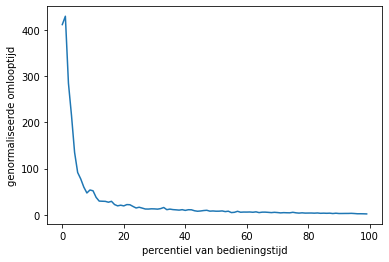

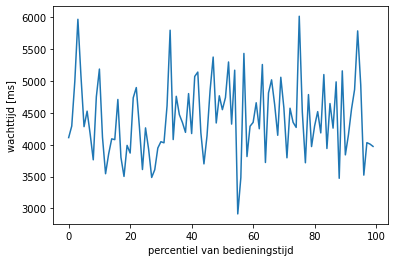

FCFS voor 20000 processen
gemiddelde omlooptijd bedraagt: 536.4218
gemiddelde genormaliseerde omlooptijd bedraagt: 22.967932932488004
gemiddelde wachttijd bedraagt: 435.63885


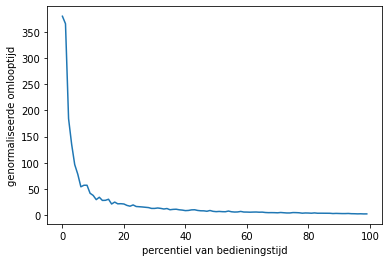

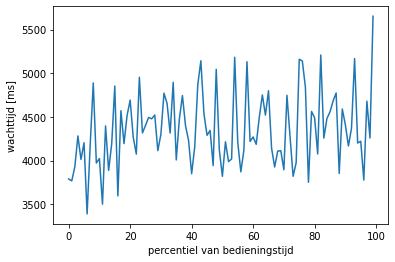

In [6]:
# uitvoeren van de scheduler en berekenen van de grootheden per proces:
def FCFS(df):
    df_fcfs = df.copy()
    df_fcfs["starttime"] = df_fcfs["arrivaltime"]
    df_fcfs["waittime"] = 0
    df_fcfs["endtime"] = df_fcfs["arrivaltime"] + df_fcfs["servicetime"]

    for i in range(1, len(df_fcfs)):
        # als het proces toekomt alvorens het vorige proces klaar is (deze if loop is als het ware de scheduler):
        if df_fcfs.at[i-1, "endtime"] > df_fcfs.at[i, "arrivaltime"]: 
            # wachttijd berekenen
            df_fcfs.at[i, "waittime"] = df_fcfs.at[i-1, "endtime"] - df_fcfs.at[i, "arrivaltime"] 
            # starttijd bijstellen met wachttijd
            df_fcfs.at[i, "starttime"] = df_fcfs.at[i-1, "endtime"] 
        # eindtijd berekenen op basis van (aangepaste) starttijd en bedieningstijd
        df_fcfs.at[i, "endtime"] = df_fcfs.at[i, "starttime"] + df_fcfs.at[i, "servicetime"] 
    # Na het uitvoeren van de scheduler berekenen we de TAT zoals gezien in de les: service time + wait time    
    df_fcfs["TAT"] = df_fcfs["servicetime"] + df_fcfs["waittime"]
    # idem voor de genormaliseerde TAT:
    df_fcfs["normTAT"] = df_fcfs["TAT"]/df_fcfs["servicetime"]
    
    return df_fcfs

evaluate(FCFS(df_10000), "FCFS voor 10000 processen")    
evaluate(FCFS(df_20000), "FCFS voor 20000 processen") 

### SJF
(In de cursus SPN = Shortest Process Next) </br>
Shortest Job First. Implementatie: telkens er overgegaan wordt op een ander proces, eerst steeds alle processen in wacht sorteren op service time, dan in volgorde uitvoeren.

SJF voor 10000 processen
gemiddelde omlooptijd bedraagt: 540.628925785157
gemiddelde genormaliseerde omlooptijd bedraagt: 26.94106878134379
gemiddelde wachttijd bedraagt: 440.98389677935586


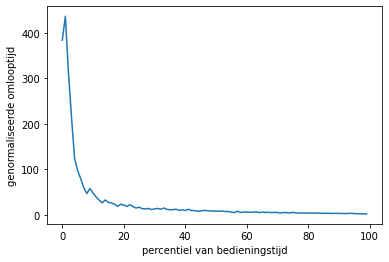

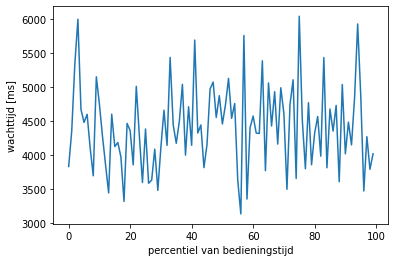

SJF voor 20000 processen
gemiddelde omlooptijd bedraagt: 536.4218
gemiddelde genormaliseerde omlooptijd bedraagt: 22.967932932488004
gemiddelde wachttijd bedraagt: 435.63885


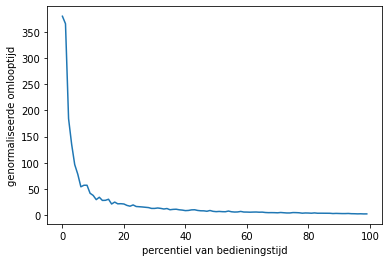

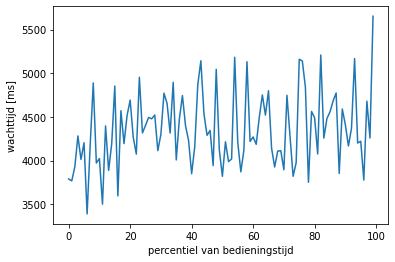

In [7]:
# uitvoeren van de scheduler en berekenen van de grootheden per proces:
# def SJF(df):
#     df_sjf = df.copy()
#     df_sjf["starttime"] = 0
#     df_sjf["waittime"] = 0
#     df_sjf["endtime"] = df_sjf["arrivaltime"] + df_sjf["servicetime"]
    
#     df_sjf.sort_values('arrivaltime', axis = 0)
    
#     t = df_sjf.at[0, "arrivaltime"]
#     queue = []
#     done = []
        

#     for i in range(df_sjf.shape[0]):
#         # Alle processen die in de tussentijd zijn gearriveerd toevoegen aan de queue
#         while df_sjf.at[i, "arrivaltime"] <= t:
#             if i not in done:
#                 if i not in queue:
#                     queue.append(i)
#             i = i+1
#             if i >= df_sjf.shape[0]:
#                 break
        
#         # zodat de functie niet vast komt te zitten
#         if not queue:
#             t = df_sjf.at[i, "arrivaltime"]
#             queue.append(i)
            
#         # we creëren telkens list om de queue te kunnen sorteren op service time:
#         temp = []
#         for j in queue:
#             temp.append((df_sjf.at[j, 'pid'], df_sjf.at[j, 'servicetime']))
#         temp.sort(key=lambda row: row[1])
        
#         # Nu kunnen we voor het proces in kwestie de nodige waarden invullen:
#         index = df_sjf.index[df_sjf['pid'] == temp[0][0]][0]
#         df_sjf.at[index,"starttime"] = t
#         t = t + df_sjf.at[index,"servicetime"]
#         df_sjf.at[index,"endtime"] = t
#         queue.remove(index)
#         done.append(index)
        
#     # We berekenen de wait time door van de start time de arrival time af te trekken    
#     df_sjf["waittime"] = df_sjf["starttime"] - df_sjf["arrivaltime"]
#     # We berekenen de TAT zoals gezien in de les: service time + wait time    
#     df_sjf["TAT"] = df_sjf["servicetime"] + df_sjf["waittime"]
#     # idem voor de genormaliseerde TAT:
#     df_sjf["normTAT"] = df_sjf["TAT"]/df_sjf["servicetime"]
    
#     return df_sjf

# evaluate(SJF(df_10000), "SJF voor 10000 processen")    
# evaluate(SJF(df_20000), "SJF voor 20000 processen")

def SJF(df):
    df_sjf = df.copy()
    df_sjf["starttime"] = 0
    df_sjf["waittime"] = 0
    df_sjf["endtime"] = df_sjf["arrivaltime"] + df_sjf["servicetime"]
    
    df_sjf.sort_values('arrivaltime', axis = 0)
    
    t = df_sjf.at[0, "arrivaltime"]
    todo = []
    queue = []
    done = []
    
    # we maken lijst met de processen die nog aan moeten komen en sorteren deze op arrivaltime
    for i in range(df_sjf.shape[0]):
        todo.append((df_sjf.at[i, 'pid'], df_sjf.at[i, 'arrivaltime'], df_sjf.at[i, 'servicetime']))
    
    todo.sort(key=lambda row: row[1])
    
    while todo:
        # Alle processen die in de tussentijd zijn gearriveerd toevoegen aan de queue 
        if todo:
            while todo[0][1] <= t:
                queue.append(todo.pop(0))
                if not todo:
                    break
        
        if not queue:
            t = todo[0][1]
            continue
        
        # we creëren telkens list om de queue te kunnen sorteren op service time:
        temp = []
        for j in queue:
            temp.append(j)
        temp.sort(key=lambda row: row[1])
        
        # Nu kunnen we voor het proces in kwestie de nodige waarden invullen:
        index = temp[0][0] - 1
        df_sjf.at[index,"starttime"] = t
        t = t + df_sjf.at[index,"servicetime"]
        df_sjf.at[index,"endtime"] = t
        queue.remove(temp[0])
        done.append(temp[0])

    # We berekenen de wait time door van de start time de arrival time af te trekken    
    df_sjf["waittime"] = df_sjf["starttime"] - df_sjf["arrivaltime"]
    # We berekenen de TAT zoals gezien in de les: service time + wait time    
    df_sjf["TAT"] = df_sjf["servicetime"] + df_sjf["waittime"]
    # idem voor de genormaliseerde TAT:
    df_sjf["normTAT"] = df_sjf["TAT"]/df_sjf["servicetime"]
    
    # volgende lijn is een temporary fix voor 2 afwijkende waarden in de 10000 dataset
    df_sjf.drop(df_sjf[df_sjf.waittime < 0].index, inplace=True)
    
    return df_sjf

evaluate(SJF(df_10000), "SJF voor 10000 processen")    
evaluate(SJF(df_20000), "SJF voor 20000 processen")

# TODO fouten oplossen!

### SRT
Shortest Remaining Time. Implementatie: opnieuw werken met een queue die steeds op de juiste momenten bepaalt welk proces het minste tijd resterend heeft.

In [8]:
def SRT(df):
    df_srt = df.copy()
    df_srt["starttime"] = 0
    df_srt["waittime"] = 0
    df_srt["endtime"] = 0
    df_srt["rem_st"] = df_srt["servicetime"]  # extra kolom om de resterende service time bij te houden
    
    t = 0
    df_srt.sort_values('arrivaltime')  # sorteren op arrival time
    queue = []
    
    # beginnen bij het eerst gearriveerde proces
    for i in range(df_srt.shape[0]-1):
        # proces op de queue zetten
        queue.append(i)
        # zolang er geen nieuwkomer is op de FCFS queue gewoon de bestaande queue afwerken
        while t < df_srt.at[i+1, "arrivaltime"]:
            # Als er geen processen in de queue zitten onmiddelijk doorgaan naar het volgende proces
            if not queue:
                t = df_srt.at[i+1, "arrivaltime"]
                break
            
            rem_st = df_srt.at[i, "rem_st"]
            
            for j in queue:

                # HIER VERDER WERKEN
                # bepalen welk proces de laagste uitvoeringstijd heeft
                if df_srt.at[j, "rem_st"] > q:    
                    t = t + q
                    df_srt.at[j, "rem_st"] = df_rr.at[j, "rem_st"] - q
                elif df_srt.at[j, "rem_st"] == q:
                    t = t + q
                    df_srt.at[j, "rem_st"] = 0
                    df_srt.at[j, "endtime"] = t
                    queue.remove(j)
                else:
                    t = t + df_srt.at[j, "rem_st"]
                    df_srt.at[j, "rem_st"] = 0
                    df_srt.at[j, "endtime"] = t
                    queue.remove(j)
                    
                # als het proces voor de eerste keer aan de beurt is starttijd invullen en wacht tijd bijtellen waar nodig
                if df_srt.at[j, "starttime"] == 0:
                    df_srt.at[j, "starttime"] = t
                    df_srt.at[j, "waittime"] = df_srt.at[j, "waittime"] + df_srt.at[j, "starttime"] - df_srt.at[j, "arrivaltime"]
        
    # laatste proces nog correct toevoegen aan de queue en afhandelen
    queue.append(df_rr.shape[0]-1)
    while queue:
        for j in queue:
            # als het proces voor de eerste keer aan de beurt is starttijd invullen en wacht tijd bijtellen waar nodig
            if df_rr.at[j, "starttime"] == 0:
                df_rr.at[j, "starttime"] = t
                df_rr.at[j, "waittime"] = df_rr.at[j, "waittime"] + df_rr.at[j, "starttime"] - df_rr.at[j, "arrivaltime"]

            if df_rr.at[j, "rem_st"] > q:    
                t = t + q
                df_rr.at[j, "rem_st"] = df_rr.at[j, "rem_st"] - q
            elif df_rr.at[j, "rem_st"] == q:
                t = t + q
                df_rr.at[j, "rem_st"] = 0
                df_rr.at[j, "endtime"] = t
                queue.remove(j)
            else:
                t = t + df_rr.at[j, "rem_st"]
                df_rr.at[j, "rem_st"] = 0
                df_rr.at[j, "endtime"] = t
                queue.remove(j)
                
    # Als de queue volledig is afgewerkt doen we nog de laatste berekeningen:
    ## we stellen de wait time bij, wacht tijd - start tijd - service tijd komt overeen met de tijd gespendeerd in wacht na de start
    df_rr["waittime"] = df_rr["waittime"] + (df_rr["endtime"] - df_rr["starttime"] - df_rr["servicetime"])
    ## we berekenen de TAT zoals gezien in de les: service time + wait time    
    df_rr["TAT"] = df_rr["servicetime"] + df_rr["waittime"]
    ## idem voor de genormaliseerde TAT:
    df_rr["normTAT"] = df_rr["TAT"]/df_rr["servicetime"]
    
    return df_rr

### RR
Round Robin. Implementatie: Processor tijd wordt gelijk verdeelt onder alle processen die gearriveerd zijn tot ze. Werken met een queue waarop elk process aankomt en op de queue blijft tot het afgewerkt is.

In [ ]:
# RR implementatie

def RR(df, q):
    df_rr = df.copy()
    df_rr["starttime"] = -1
    df_rr["waittime"] = 0
    df_rr["endtime"] = 0
    df_rr["rem_st"] = df_rr["servicetime"]  # extra kolom om de resterende service time bij te houden
    
    t = 0
    df_rr.sort_values('arrivaltime')  # sorteren op arrival time
    queue = []
    i=0
    j=0
    
    
    # beginnen bij het eerst gearriveerde proces
    while i < df_rr.shape[0]-1:
        # proces op de queue zetten
        queue.append(i)
        queue.append(queue.pop(len(queue)-2))
        # zolang er geen nieuwkomer is op de FCFS queue gewoon de bestaande queue afwerken
        while queue:
            if t < df_rr.at[i+1, "arrivaltime"]:
                print(queue)
                j = queue[0]
                print(j)

                # als het proces voor de eerste keer aan de beurt is starttijd invullen en wacht tijd bijtellen waar nodig
                if df_rr.at[j, "starttime"] == -1:
                    df_rr.at[j, "starttime"] = t
                    df_rr.at[j, "waittime"] = df_rr.at[j, "waittime"] + df_rr.at[j, "starttime"] - df_rr.at[j, "arrivaltime"]

                # telkens gedurende q tijd laten lopen en afhankelijk van de resterende benodigde tijd afhandelen
                if df_rr.at[j, "rem_st"] > q:    
                    t = t + q
                    df_rr.at[j, "rem_st"] = df_rr.at[j, "rem_st"] - q
                    queue.append(queue.pop(0))

                # Als er nog maar q of minder tijd rest, afwerken en van de queue halen
                else:
                    t = t + df_rr.at[j, "rem_st"]
                    df_rr.at[j, "rem_st"] = 0
                    df_rr.at[j, "endtime"] = t
                    queue.pop(0)
            
            else:
                # als er een nieuwkomer is op de queue, huidige loop afbreken
                i = i+1
                break
        if not queue:
            # Als er geen processen in de queue zitten onmiddelijk doorgaan naar het volgende proces
            i = i+1
            if t < df_rr.at[i, "arrivaltime"]:
                t = df_rr.at[i, "arrivaltime"]



                
            
        
    # laatste proces nog correct toevoegen aan de queue en afhandelen
    queue.append(df_rr.shape[0]-1)
    while queue:
        print(queue)
        j = queue[0]
        print(j)

        # als het proces voor de eerste keer aan de beurt is starttijd invullen en wacht tijd bijtellen waar nodig
        if df_rr.at[j, "starttime"] == -1:
            df_rr.at[j, "starttime"] = t
            df_rr.at[j, "waittime"] = df_rr.at[j, "waittime"] + df_rr.at[j, "starttime"] - df_rr.at[j, "arrivaltime"]

        # telkens gedurende q tijd laten lopen en afhankelijk van de resterende benodigde tijd afhandelen
        if df_rr.at[j, "rem_st"] > q:    
            t = t + q
            df_rr.at[j, "rem_st"] = df_rr.at[j, "rem_st"] - q

            queue.append(queue.pop(0))

        # Als er nog maar q of minder tijd rest, afwerken en van de queue halen
        else:
            t = t + df_rr.at[j, "rem_st"]
            df_rr.at[j, "rem_st"] = 0
            df_rr.at[j, "endtime"] = t
            queue.pop(0)

    # Als de queue volledig is afgewerkt doen we nog de laatste berekeningen:
    ## we stellen de wait time bij, wacht tijd - start tijd - service tijd komt overeen met de tijd gespendeerd in wacht na de start
    df_rr["waittime"] = df_rr["waittime"] + (df_rr["endtime"] - df_rr["starttime"] - df_rr["servicetime"])
    ## we berekenen de TAT zoals gezien in de les: service time + wait time    
    df_rr["TAT"] = df_rr["servicetime"] + df_rr["waittime"]
    ## idem voor de genormaliseerde TAT:
    df_rr["normTAT"] = df_rr["TAT"]/df_rr["servicetime"]
    
    return df_rr

evaluate(RR(df_10000,2), "RR voor 10000 processen met q = 2")  
evaluate(RR(df_20000,2), "RR voor 20000 processen met q = 2")
evaluate(RR(df_10000,4), "RR voor 10000 processen met q = 4")    
evaluate(RR(df_20000,4), "RR voor 20000 processen met q = 4")
evaluate(RR(df_10000,8), "RR voor 10000 processen met q = 8")    
evaluate(RR(df_20000,8), "RR voor 20000 processen met q = 8")

[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]
1
[2, 1]
2
[1, 2]


### HRRN
Highest Response Ratio Next. Implementatie:

### MLFB
MultiLevel FeedBack mode. Implementatie: (2 versies)

In [10]:
df_temp = df_10000.copy()
df_temp.sort_values('arrivaltime', axis = 0)
df_temp.head()

,pid,arrivaltime,servicetime
0,1,209,46
1,2,336,220
2,3,486,82
3,4,772,165
4,5,825,188


In [ ]:
df_temp.head()